# Load MNIST Dataset

In [1]:
import numpy as np

# 저장했던 .npz 파일 불러오기
mnist_train = np.load('mnist_train.npz')

# 저장할 때 부여했던 이름(키)으로 각 배열에 접근
X_train = mnist_train['train_images']
y_train = mnist_train['train_labels']

print("불러온 데이터 확인:")
print(f"학습용 이미지 shape: {X_train.shape}")
print(f"학습용 라벨 shape: {y_train.shape}")

# 파일에 어떤 키들이 저장되어 있는지 확인
# print("\n파일에 저장된 키 목록:", list(mnist_train.keys()))

불러온 데이터 확인:
학습용 이미지 shape: (60000, 28, 28)
학습용 라벨 shape: (60000,)


# Foreground - Background Color Generation for MNIST

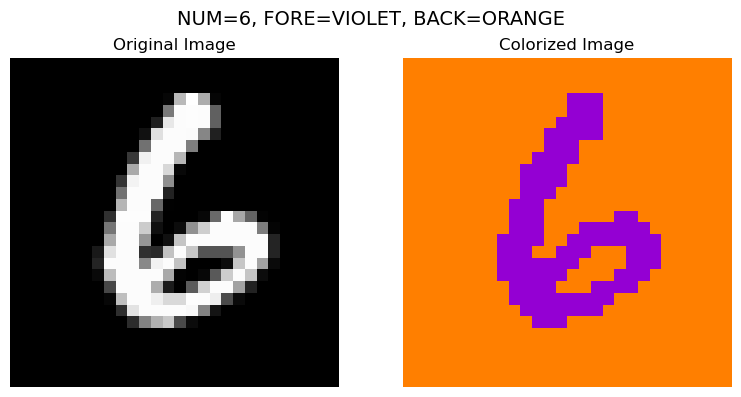

In [2]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터셋을 로드합니다.
mnist_train = np.load('mnist_train.npz')

images = mnist_train['train_images']
labels = mnist_train['train_labels']

# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit_with_threshold(digit_image, fg_color, bg_color):
    """
    숫자 이미지에 임계값을 적용하여 경계선 번짐 없이 선명한 전경/배경 색을 적용합니다.
    """
    gray_image = digit_image.convert('L')
    threshold = 128
    mask = gray_image.point(lambda p: 255 if p > threshold else 0)
    final_image = Image.new("RGB", digit_image.size, bg_color)
    final_image.paste(fg_color, mask=mask)
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(images))
image = images[idx]
label = labels[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
    bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
final_image = colorize_digit_with_threshold(pil_image, fg_color, bg_color)


if final_image is not None:
  # ------------------- #
  #  plotting 부분 수정  #
  # ------------------- #

  # 1행 2열의 서브플롯(그래프 영역)을 생성합니다.
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))

  # 왼쪽(첫 번째) 서브플롯에 원본 이미지를 표시합니다.
  axes[0].imshow(image.squeeze(), cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off') # 축을 숨깁니다.

  # 오른쪽(두 번째) 서브플롯에 색상 적용된 이미지를 표시합니다.
  axes[1].imshow(final_image)
  axes[1].set_title('Colorized Image')
  axes[1].axis('off') # 축을 숨깁니다.

  # 전체 플롯의 제목을 설정합니다.
  fig.suptitle(f'NUM={label}, FORE={fg_label}, BACK={bg_label}', fontsize=14)

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()

# Handwritten Image Generation using Custom Fonts

In [3]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from glob import glob

# ./fonts/ 경로 아래의 모든 .ttf 폰트 파일을 재귀적으로 탐색합니다.
FONT_PATHS = glob('./fonts/**/*.ttf', recursive=True)

# MNIST와 유사한 이미지 크기와 폰트 크기 설정
IMAGE_SIZE = (28, 28)  # 이미지 크기 (28x28)
FONT_SIZE = 25         # 폰트 크기

def generate_digit_image(digit, font_path):
    """주어진 폰트로 특정 숫자 이미지를 생성하는 함수"""
    # 흰 배경(255)의 그레이스케일("L") 이미지를 생성합니다.
    image = Image.new("L", IMAGE_SIZE, 255)
    draw = ImageDraw.Draw(image)

    try:
        # 지정된 경로에서 폰트를 불러옵니다.
        font = ImageFont.truetype(font_path, FONT_SIZE)
    except IOError:
        # 폰트를 불러올 수 없는 경우 오류 메시지를 출력하고 None을 반환합니다.
        print(f"폰트를 불러올 수 없습니다: {font_path}")
        return None

    # 숫자의 경계 상자를 계산하여 너비와 높이를 구합니다.
    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width = bbox[2] - bbox[0]
    
    # 텍스트를 이미지의 가로 중앙, 세로 상단에 배치합니다.
    position = ((IMAGE_SIZE[0] - text_width) // 2, -3)

    # 검은색(0)으로 숫자를 이미지에 그립니다.
    draw.text(position, str(digit), fill=0, font=font)

    return np.array(image)

# 0에서 9 사이의 랜덤 숫자를 선택합니다.
digit = random.randint(0, 9)

# 폰트 리스트에서 랜덤하게 하나를 선택합니다.
font_path = random.choice(FONT_PATHS)

# 선택된 폰트로 숫자 이미지를 생성합니다.
image = generate_digit_image(digit, font_path)
image = 1 - image

# 이미지가 성공적으로 생성되었는지 확인합니다.
if image is not None:
    # 생성된 이미지를 화면에 표시합니다 (cmap='gray'는 값이 낮을수록 어둡게 표시).
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"NUM={digit}, FONT={os.path.basename(font_path)}")
    
    plt.tight_layout()
    plt.show()

IndexError: Cannot choose from an empty sequence

# Foreground - Background Color Generation for Handwritten Image

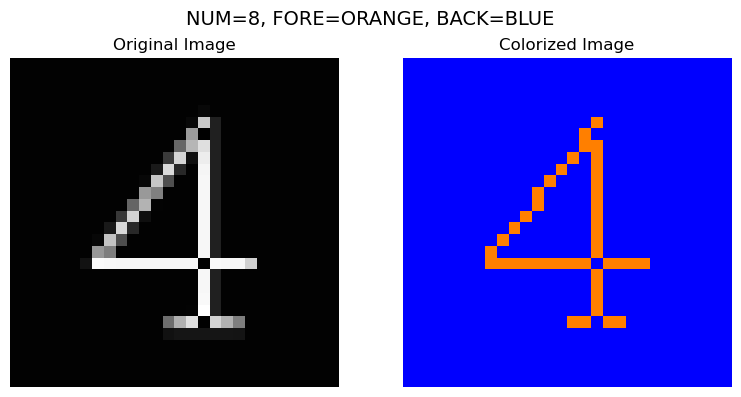

In [78]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from glob import glob

# ./fonts/ 경로 아래의 모든 .ttf 폰트 파일을 재귀적으로 탐색합니다.
FONT_PATHS = glob('./fonts/**/*.ttf', recursive=True)

# MNIST와 유사한 이미지 크기와 폰트 크기 설정
IMAGE_SIZE = (28, 28)  # 이미지 크기 (28x28)
FONT_SIZE = 25         # 폰트 크기

def generate_digit_image(digit, font_path):
    """주어진 폰트로 특정 숫자 이미지를 생성하는 함수"""
    # 흰 배경(255)의 그레이스케일("L") 이미지를 생성합니다.
    image = Image.new("L", IMAGE_SIZE, 255)
    draw = ImageDraw.Draw(image)

    try:
        # 지정된 경로에서 폰트를 불러옵니다.
        font = ImageFont.truetype(font_path, FONT_SIZE)
    except IOError:
        # 폰트를 불러올 수 없는 경우 오류 메시지를 출력하고 None을 반환합니다.
        print(f"폰트를 불러올 수 없습니다: {font_path}")
        return None

    # 숫자의 경계 상자를 계산하여 너비와 높이를 구합니다.
    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width = bbox[2] - bbox[0]
    
    # 텍스트를 이미지의 가로 중앙, 세로 상단에 배치합니다.
    position = ((IMAGE_SIZE[0] - text_width) // 2, -3)

    # 검은색(0)으로 숫자를 이미지에 그립니다.
    draw.text(position, str(digit), fill=0, font=font)

    return np.array(image)

# 0에서 9 사이의 랜덤 숫자를 선택합니다.
digit = random.randint(0, 9)

# 폰트 리스트에서 랜덤하게 하나를 선택합니다.
font_path = random.choice(FONT_PATHS)

# 선택된 폰트로 숫자 이미지를 생성합니다.
image = generate_digit_image(digit, font_path)
image = 1 - image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
    bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
final_image = colorize_digit_with_threshold(pil_image, fg_color, bg_color)

if final_image is not None:
  # ------------------- #
  #  plotting 부분 수정  #
  # ------------------- #

  # 1행 2열의 서브플롯(그래프 영역)을 생성합니다.
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))

  # 왼쪽(첫 번째) 서브플롯에 원본 이미지를 표시합니다.
  axes[0].imshow(image.squeeze(), cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off') # 축을 숨깁니다.

  # 오른쪽(두 번째) 서브플롯에 색상 적용된 이미지를 표시합니다.
  axes[1].imshow(final_image)
  axes[1].set_title('Colorized Image')
  axes[1].axis('off') # 축을 숨깁니다.

  # 전체 플롯의 제목을 설정합니다.
  fig.suptitle(f'NUM={label}, FORE={fg_label}, BACK={bg_label}', fontsize=14)

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()